In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import nibabel as nib
import numpy as np

In [ ]:
'''
=====================================================
********   Defining Segmentation classes  ***********
=====================================================
'''

SEGMENTATION_CLASS = {
    0 : 'NOT TUMOR',
    1 : 'NECROTIC AND NON-ENHANCING TUMOR CORE',
    2 : 'PERITUMORAL EDEMA',
    3 : 'GD ENHANCING TUMOR',
}


In [ ]:
'''
==============================================
** Defining the original (raw) dataset path **
==============================================
'''

DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

In [ ]:
train_val_directories = [f.path for f in os.scandir(DATASET_PATH) if f.is_dir()]
train_val_directories.remove(DATASET_PATH + 'BraTS20_Training_355')
print(len(train_val_directories))

368


In [ ]:
def getDataIds(directoryList):
    dataIds = []
    for i in range(0, len(directoryList)):
        dataIds.append(directoryList[i][directoryList[i].rfind('/') + 1 :] )
    return dataIds

train_and_test_ids = getDataIds(train_val_directories)
print(len(train_and_test_ids))
train_and_test_ids[0:10]

368


['BraTS20_Training_083',
 'BraTS20_Training_337',
 'BraTS20_Training_161',
 'BraTS20_Training_198',
 'BraTS20_Training_284',
 'BraTS20_Training_169',
 'BraTS20_Training_157',
 'BraTS20_Training_073',
 'BraTS20_Training_253',
 'BraTS20_Training_026']

In [ ]:
print("Total pixels in one brain input including background : (155*240*240) :",  155*240*240)

Total pixels in one brain input including background : (155*240*240) : 8928000


In [ ]:
VOLUME_SLICES = 155

In [ ]:
def getBrainVolumeInPixels(brain_data):
    'To get the number of pixels contributing to the entire brain volume'
    total_brain_volume_pixels = 0
    for i in range(VOLUME_SLICES):
        flatten_slice = brain_data[:, :, i].flatten()
        brain_pixels_in_slice = np.count_nonzero(flatten_slice)
        total_brain_volume_pixels += brain_pixels_in_slice
    return total_brain_volume_pixels

In [ ]:
def getMaskVolumeInPixels(brain_segmented_data):
    'To get the number of pixels contributing to each of the 4 segmentation classes'
    mask_volumes = dict([(0, 0), (1,0), (2,0), (3,0)])
    for i in range(VOLUME_SLICES):
        flatten_slice = brain_segmented_data[:, :, i].flatten()
        flatten_slice[flatten_slice == 4] = 3
        
        unique, count = np.unique(flatten_slice, return_counts=True)
        unique = unique.astype(int)
        values_dict = dict(zip(unique, count))
#         print(f'slice {i} : {values_dict}')
        for segment_class_index in range(1,4):
            mask_volumes[segment_class_index] += values_dict.get(segment_class_index, 0)
    return mask_volumes

# **Let's check the above function on sample brain volume**

In [ ]:
sample_brain_volume_t1 = nib.load(os.path.join(DATASET_PATH, f'{train_and_test_ids[0]}/{train_and_test_ids[0]}_t1.nii')).get_fdata()
sample_brain_volume_t2 = nib.load(os.path.join(DATASET_PATH, f'{train_and_test_ids[0]}/{train_and_test_ids[0]}_t2.nii')).get_fdata()
sample_brain_volume_t1ce = nib.load(os.path.join(DATASET_PATH, f'{train_and_test_ids[0]}/{train_and_test_ids[0]}_t1ce.nii')).get_fdata()
sample_brain_volume_flair = nib.load(os.path.join(DATASET_PATH, f'{train_and_test_ids[0]}/{train_and_test_ids[0]}_flair.nii')).get_fdata()
sample_brain_volume_segmented = nib.load(os.path.join(DATASET_PATH, f'{train_and_test_ids[0]}/{train_and_test_ids[0]}_seg.nii')).get_fdata()

In [ ]:
print('shape of t1 volume   :', sample_brain_volume_t1.shape)
print('shape of t1ce volume :',sample_brain_volume_t1ce.shape)
print('shape of t2 volume   :',sample_brain_volume_t2.shape)
print('shape of flair volume:',sample_brain_volume_flair.shape)
print('shape of seg volume  :',sample_brain_volume_segmented.shape)

shape of t1 volume   : (240, 240, 155)
shape of t1ce volume : (240, 240, 155)
shape of t2 volume   : (240, 240, 155)
shape of flair volume: (240, 240, 155)
shape of seg volume  : (240, 240, 155)


In [ ]:
print(f'Total pixels contributing to the brain [T1]   : {getBrainVolumeInPixels(sample_brain_volume_t1)}')
print(f'Total pixels contributing to the brain [T1ce] : {getBrainVolumeInPixels(sample_brain_volume_t1ce)}')
print(f'Total pixels contributing to the brain [T2]   : {getBrainVolumeInPixels(sample_brain_volume_t2)}')
print(f'Total pixels contributing to the brain [Flair]: {getBrainVolumeInPixels(sample_brain_volume_flair)}')

brain_volume_pixels = (getBrainVolumeInPixels(sample_brain_volume_t1) + getBrainVolumeInPixels(sample_brain_volume_t1ce) + getBrainVolumeInPixels(sample_brain_volume_t2) + getBrainVolumeInPixels(sample_brain_volume_flair))//4
print(f"final conclusion : {brain_volume_pixels}")

Total pixels contributing to the brain [T1]   : 1547803
Total pixels contributing to the brain [T1ce] : 1547803
Total pixels contributing to the brain [T2]   : 1547692
Total pixels contributing to the brain [Flair]: 1547785
final conclusion : 1547770


In [ ]:
for i in range(VOLUME_SLICES):
    print(np.max(np.unique(sample_brain_volume_t1[:, :, i].flatten())),    np.max(np.unique(sample_brain_volume_t2[:, :, i].flatten())),    np.max(np.unique(sample_brain_volume_t1ce[:, :, i].flatten())),    np.max(np.unique(sample_brain_volume_flair[:, :, i].flatten())))

348.0 390.0 572.0 737.0
341.0 446.0 575.0 572.0
380.0 438.0 607.0 421.0
385.0 429.0 762.0 504.0
402.0 440.0 779.0 450.0
421.0 410.0 822.0 431.0
388.0 413.0 869.0 445.0
399.0 443.0 865.0 385.0
416.0 447.0 919.0 403.0
413.0 472.0 1005.0 398.0
430.0 471.0 946.0 426.0
427.0 466.0 933.0 462.0
417.0 453.0 1082.0 436.0
440.0 472.0 978.0 471.0
436.0 406.0 888.0 451.0
445.0 460.0 874.0 466.0
445.0 470.0 945.0 543.0
457.0 524.0 930.0 486.0
450.0 476.0 985.0 618.0
453.0 456.0 987.0 601.0
466.0 488.0 1005.0 513.0
482.0 461.0 1024.0 442.0
469.0 484.0 1002.0 401.0
487.0 458.0 1010.0 388.0
464.0 474.0 1047.0 433.0
467.0 476.0 1040.0 406.0
481.0 478.0 1037.0 365.0
449.0 496.0 1123.0 360.0
447.0 466.0 1284.0 400.0
502.0 524.0 1316.0 404.0
498.0 482.0 1301.0 443.0
485.0 469.0 1279.0 441.0
503.0 484.0 1271.0 704.0
641.0 477.0 1249.0 654.0
559.0 454.0 1231.0 567.0
565.0 449.0 1306.0 472.0
515.0 464.0 1391.0 572.0
522.0 473.0 1291.0 514.0
527.0 463.0 1221.0 517.0
540.0 457.0 1231.0 523.0
562.0 459.0 1193.0

In [ ]:
mask_volumes = getMaskVolumeInPixels(sample_brain_volume_segmented)
mask_volumes[0] = brain_volume_pixels - (mask_volumes[1] + mask_volumes[2] + mask_volumes[3])
mask_volumes

slice 0 : {0: 57600}
slice 1 : {0: 57600}
slice 2 : {0: 57600}
slice 3 : {0: 57600}
slice 4 : {0: 57600}
slice 5 : {0: 57600}
slice 6 : {0: 57600}
slice 7 : {0: 57600}
slice 8 : {0: 57600}
slice 9 : {0: 57600}
slice 10 : {0: 57600}
slice 11 : {0: 57600}
slice 12 : {0: 57600}
slice 13 : {0: 57600}
slice 14 : {0: 57600}
slice 15 : {0: 57600}
slice 16 : {0: 57600}
slice 17 : {0: 57600}
slice 18 : {0: 57600}
slice 19 : {0: 57600}
slice 20 : {0: 57600}
slice 21 : {0: 57600}
slice 22 : {0: 57600}
slice 23 : {0: 57600}
slice 24 : {0: 57600}
slice 25 : {0: 57600}
slice 26 : {0: 57600}
slice 27 : {0: 57600}
slice 28 : {0: 57600}
slice 29 : {0: 57600}
slice 30 : {0: 57600}
slice 31 : {0: 57600}
slice 32 : {0: 57600}
slice 33 : {0: 57600}
slice 34 : {0: 57597, 2: 3}
slice 35 : {0: 57596, 2: 4}
slice 36 : {0: 57596, 2: 4}
slice 37 : {0: 57596, 2: 4}
slice 38 : {0: 57594, 2: 6}
slice 39 : {0: 57558, 2: 42}
slice 40 : {0: 57511, 2: 89}
slice 41 : {0: 57485, 2: 115}
slice 42 : {0: 57415, 2: 185}
slic

{0: 1474112, 1: 3391, 2: 63100, 3: 7167}

In [ ]:
import pandas as pd

In [ ]:
survival_df = pd.read_csv(DATASET_PATH + '/survival_info.csv')
survival_df.head()

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR


In [ ]:
survival_df.drop(survival_df[survival_df['Extent_of_Resection'] != 'GTR'].index, inplace=True)
survival_df = survival_df.drop(['Extent_of_Resection'], axis=1)
survival_df = survival_df.reset_index(drop = True)
survival_df

,Brats20ID,Age,Survival_days
0,BraTS20_Training_001,60.463,289
1,BraTS20_Training_002,52.263,616
2,BraTS20_Training_003,54.301,464
3,BraTS20_Training_004,39.068,788
4,BraTS20_Training_005,68.493,465
...,...,...,...
114,BraTS20_Training_360,50.000,540
115,BraTS20_Training_363,57.000,62
116,BraTS20_Training_366,72.000,633
117,BraTS20_Training_368,49.000,442


In [ ]:
mask_volumes_df_list = {seg: [] for seg in SEGMENTATION_CLASS.values()}
mask_volumes_df_list

{'NOT TUMOR': [],
 'NECROTIC AND NON-ENHANCING TUMOR CORE': [],
 'PERITUMORAL EDEMA': [],
 'GD ENHANCING TUMOR': []}

In [ ]:
def generateData(data_ids):
    mask_volumes_df_list = {seg: [] for seg in SEGMENTATION_CLASS.values()}
    for data_id in data_ids:
            brain_volume_t1 = nib.load(os.path.join(DATASET_PATH, f'{data_id}/{data_id}_t1.nii')).get_fdata()
            brain_volume_t2 = nib.load(os.path.join(DATASET_PATH, f'{data_id}/{data_id}_t2.nii')).get_fdata()
            brain_volume_t1ce = nib.load(os.path.join(DATASET_PATH, f'{data_id}/{data_id}_t1ce.nii')).get_fdata()
            brain_volume_flair = nib.load(os.path.join(DATASET_PATH, f'{data_id}/{data_id}_flair.nii')).get_fdata()
            brain_volume_segmented = nib.load(os.path.join(DATASET_PATH, f'{data_id}/{data_id}_seg.nii')).get_fdata()
            
            brain_volume_pixels = (getBrainVolumeInPixels(brain_volume_t1) + 
                                   getBrainVolumeInPixels(brain_volume_t1ce) + 
                                   getBrainVolumeInPixels(brain_volume_t2) + 
                                   getBrainVolumeInPixels(brain_volume_flair))//4
            
            
            mask_volumes = getMaskVolumeInPixels(brain_volume_segmented)
            mask_volumes[0] = brain_volume_pixels - (mask_volumes[1] + mask_volumes[2] + mask_volumes[3])
            
            print(f"{data_id}:", mask_volumes, end=" ")

            for c in range(4):
                mask_volumes[c] = mask_volumes[c]/brain_volume_pixels
                
            print(f"{data_id}:", mask_volumes)
            
            for key in SEGMENTATION_CLASS.keys():
                mask_volumes_df_list[SEGMENTATION_CLASS[key]].append(mask_volumes[key])

    return mask_volumes_df_list

   
mask_volumes_df_list = generateData(survival_df["Brats20ID"].values)

BraTS20_Training_001: {0: 1130906, 1: 15443, 2: 168794, 3: 27742} BraTS20_Training_001: {0: 0.8421465724913153, 1: 0.011499867821890929, 2: 0.1256950520707283, 3: 0.02065850761606541}
BraTS20_Training_002: {0: 1472189, 1: 9160, 2: 51299, 3: 6549} BraTS20_Training_002: {0: 0.9564656116143677, 1: 0.005951155050328191, 2: 0.03332841735008579, 3: 0.004254815985218267}
BraTS20_Training_003: {0: 1231313, 1: 733, 2: 26076, 3: 2998} BraTS20_Training_003: {0: 0.9763646599847754, 1: 0.0005812293834052271, 2: 0.020676858665313373, 3: 0.002377251966505963}
BraTS20_Training_004: {0: 1419622, 1: 10902, 2: 77096, 3: 15498} BraTS20_Training_004: {0: 0.9320499134013255, 1: 0.00715768574726318, 2: 0.05061722072748139, 3: 0.01017518012392999}
BraTS20_Training_005: {0: 1419704, 1: 3624, 2: 7553, 3: 10786} BraTS20_Training_005: {0: 0.9847655526553636, 1: 0.002513756644218117, 2: 0.0052390739331620965, 3: 0.0074816167672562385}
BraTS20_Training_006: {0: 1329194, 1: 19827, 2: 94456, 3: 24947} BraTS20_Trainin

In [ ]:
len(mask_volumes_df_list['NOT TUMOR'])

119

# cross check the values for any one of the data_id

In [ ]:
test_brain_volume_t1 = nib.load(os.path.join(DATASET_PATH, 'BraTS20_Training_113/BraTS20_Training_113_t1.nii')).get_fdata()
test_brain_volume_t2 = nib.load(os.path.join(DATASET_PATH, 'BraTS20_Training_113/BraTS20_Training_113_t2.nii')).get_fdata()
test_brain_volume_t1ce = nib.load(os.path.join(DATASET_PATH, 'BraTS20_Training_113/BraTS20_Training_113_t1ce.nii')).get_fdata()
test_brain_volume_flair = nib.load(os.path.join(DATASET_PATH, 'BraTS20_Training_113/BraTS20_Training_113_flair.nii')).get_fdata()


In [ ]:
test_brain_volume_pixels = (getBrainVolumeInPixels(test_brain_volume_t1) + getBrainVolumeInPixels(test_brain_volume_t1ce) + getBrainVolumeInPixels(test_brain_volume_t2) + getBrainVolumeInPixels(test_brain_volume_flair))//4
print(f"final conclusion : {test_brain_volume_pixels}")

final conclusion : 1421921


In [ ]:
test_brain_volume_segmented = nib.load(os.path.join(DATASET_PATH, 'BraTS20_Training_113/BraTS20_Training_113_seg.nii')).get_fdata()
test_mask_volumes = getMaskVolumeInPixels(test_brain_volume_segmented)
test_mask_volumes[0] =  test_brain_volume_pixels - (test_mask_volumes[1] + test_mask_volumes[2] + test_mask_volumes[3])
test_mask_volumes

{0: 1296241, 1: 2346, 2: 119083, 3: 4251}

In [ ]:
# {0: 1296241, 1: 2346, 2: 119083, 3: 4251} matching with the data generated.

# Appending the mask volumes to the existing survival dataframe

In [ ]:
for seg_key in mask_volumes_df_list:
    survival_df[seg_key] = mask_volumes_df_list[seg_key]
survival_df

,Brats20ID,Age,Survival_days,NOT TUMOR,NECROTIC AND NON-ENHANCING TUMOR CORE,PERITUMORAL EDEMA,GD ENHANCING TUMOR
0,BraTS20_Training_001,60.463,289,0.842147,0.011500,0.125695,0.020659
1,BraTS20_Training_002,52.263,616,0.956466,0.005951,0.033328,0.004255
2,BraTS20_Training_003,54.301,464,0.976365,0.000581,0.020677,0.002377
3,BraTS20_Training_004,39.068,788,0.932050,0.007158,0.050617,0.010175
4,BraTS20_Training_005,68.493,465,0.984766,0.002514,0.005239,0.007482
...,...,...,...,...,...,...,...
114,BraTS20_Training_360,50.000,540,0.898559,0.013138,0.043237,0.045065
115,BraTS20_Training_363,57.000,62,0.910677,0.017722,0.037071,0.034530
116,BraTS20_Training_366,72.000,633,0.956170,0.003713,0.021395,0.018722
117,BraTS20_Training_368,49.000,442,0.938822,0.000976,0.047992,0.012210


# Storing the original (not normalized) survival data with mask volumes GTR only

In [ ]:
survival_df.to_csv('survival_processed_data_with_mask_volumes_not_normalized.csv', index=False)

In [ ]:
survival_df.loc[survival_df['Brats20ID'] == 'BraTS20_Training_113']

,Brats20ID,Age,Survival_days,NOT TUMOR,NECROTIC AND NON-ENHANCING TUMOR CORE,PERITUMORAL EDEMA,GD ENHANCING TUMOR
78,BraTS20_Training_113,70.622,684,0.911613,0.00165,0.083748,0.00299


Cross Check
===========
BraTS20_Training_113: {0: 1296241, 1: 2346, 2: 119083, 3: 4251} BraTS20_Training_113: {0: 0.9116125298100246, 1: 0.0016498806895741747, 2: 0.08374797193374316, 3: 0.0029896175666580633}


# Survival Prediction


In [1]:
from google.colab import drive
import os
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [3]:
survival_df=pd.read_csv("/content/drive/MyDrive/Dataset/survival_processed_data_with_mask_volumes_not_normalized (1).csv")

In [4]:
survival_df

,Brats20ID,Age,Survival_days,NOT TUMOR,NECROTIC AND NON-ENHANCING TUMOR CORE,PERITUMORAL EDEMA,GD ENHANCING TUMOR
0,BraTS20_Training_001,60.463,289,0.842147,0.011500,0.125695,0.020659
1,BraTS20_Training_002,52.263,616,0.956466,0.005951,0.033328,0.004255
2,BraTS20_Training_003,54.301,464,0.976365,0.000581,0.020677,0.002377
3,BraTS20_Training_004,39.068,788,0.932050,0.007158,0.050617,0.010175
4,BraTS20_Training_005,68.493,465,0.984766,0.002514,0.005239,0.007482
...,...,...,...,...,...,...,...
114,BraTS20_Training_360,50.000,540,0.898559,0.013138,0.043237,0.045065
115,BraTS20_Training_363,57.000,62,0.910677,0.017722,0.037071,0.034530
116,BraTS20_Training_366,72.000,633,0.956170,0.003713,0.021395,0.018722
117,BraTS20_Training_368,49.000,442,0.938822,0.000976,0.047992,0.012210


In [5]:
survival_df['Survival_days'].unique()

array(['289', '616', '464', '788', '465', '269', '503', '1155', '515',
       '495', '698', '359', '169', '368', '439', '486', '287', '576',
       '350', '332', '331', '106', '473', '1283', '89', '172', '84',
       '726', '660', '522', '597', '239', '208', '355', '152', '385',
       '453', '1592', '376', '12', '579', '614', '387', '180', '139',
       '375', '1767', '168', '345', '114', '191', '50', '58', '448',
       '401', 'ALIVE (361 days later)', '510', '296', '278', '146',
       '1527', '353', '56', '21', '1227', '182', '277', '155', '1148',
       '78', '580', '77', '427', '409', '412', '334', '74', '684', '613',
       '142', '538', '416', '240', '524', '319', '730', '336', '342',
       '688', '1410', '374', '117', '692', '120', '150', '300', '630',
       '330', '728', '540', '1076', '250', '615', '105', '1293', '260',
       '1096', '351', '184', '197', '456', '62', '633', '442', '145'],
      dtype=object)

In [6]:
survival_df.loc[survival_df['Survival_days'].str.isnumeric() != True]

,Brats20ID,Age,Survival_days,NOT TUMOR,NECROTIC AND NON-ENHANCING TUMOR CORE,PERITUMORAL EDEMA,GD ENHANCING TUMOR
56,BraTS20_Training_084,61.622,ALIVE (361 days later),0.96161,0.006763,0.019852,0.011775


In [7]:
survival_df.drop(survival_df[survival_df['Survival_days'].str.isnumeric() != True].index, inplace=True)
survival_df = survival_df.reset_index(drop = True)
survival_df

,Brats20ID,Age,Survival_days,NOT TUMOR,NECROTIC AND NON-ENHANCING TUMOR CORE,PERITUMORAL EDEMA,GD ENHANCING TUMOR
0,BraTS20_Training_001,60.463,289,0.842147,0.011500,0.125695,0.020659
1,BraTS20_Training_002,52.263,616,0.956466,0.005951,0.033328,0.004255
2,BraTS20_Training_003,54.301,464,0.976365,0.000581,0.020677,0.002377
3,BraTS20_Training_004,39.068,788,0.932050,0.007158,0.050617,0.010175
4,BraTS20_Training_005,68.493,465,0.984766,0.002514,0.005239,0.007482
...,...,...,...,...,...,...,...
113,BraTS20_Training_360,50.000,540,0.898559,0.013138,0.043237,0.045065
114,BraTS20_Training_363,57.000,62,0.910677,0.017722,0.037071,0.034530
115,BraTS20_Training_366,72.000,633,0.956170,0.003713,0.021395,0.018722
116,BraTS20_Training_368,49.000,442,0.938822,0.000976,0.047992,0.012210


In [8]:
survival_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Brats20ID                              118 non-null    object 
 1   Age                                    118 non-null    float64
 2   Survival_days                          118 non-null    object 
 3   NOT TUMOR                              118 non-null    float64
 4   NECROTIC AND NON-ENHANCING TUMOR CORE  118 non-null    float64
 5   PERITUMORAL EDEMA                      118 non-null    float64
 6   GD ENHANCING TUMOR                     118 non-null    float64
dtypes: float64(5), object(2)
memory usage: 6.6+ KB


In [9]:
survival_df = survival_df.drop(['Brats20ID'], axis = 1)
survival_df

,Age,Survival_days,NOT TUMOR,NECROTIC AND NON-ENHANCING TUMOR CORE,PERITUMORAL EDEMA,GD ENHANCING TUMOR
0,60.463,289,0.842147,0.011500,0.125695,0.020659
1,52.263,616,0.956466,0.005951,0.033328,0.004255
2,54.301,464,0.976365,0.000581,0.020677,0.002377
3,39.068,788,0.932050,0.007158,0.050617,0.010175
4,68.493,465,0.984766,0.002514,0.005239,0.007482
...,...,...,...,...,...,...
113,50.000,540,0.898559,0.013138,0.043237,0.045065
114,57.000,62,0.910677,0.017722,0.037071,0.034530
115,72.000,633,0.956170,0.003713,0.021395,0.018722
116,49.000,442,0.938822,0.000976,0.047992,0.012210


In [10]:
survival_df['Survival_days'] = survival_df['Survival_days'].astype('float')

In [11]:
survival_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Age                                    118 non-null    float64
 1   Survival_days                          118 non-null    float64
 2   NOT TUMOR                              118 non-null    float64
 3   NECROTIC AND NON-ENHANCING TUMOR CORE  118 non-null    float64
 4   PERITUMORAL EDEMA                      118 non-null    float64
 5   GD ENHANCING TUMOR                     118 non-null    float64
dtypes: float64(6)
memory usage: 5.7 KB


In [12]:
survival_df['Survival_days'].describe()

count     118.000000
mean      446.432203
std       345.279906
min        12.000000
25%       192.500000
50%       374.500000
75%       567.000000
max      1767.000000
Name: Survival_days, dtype: float64

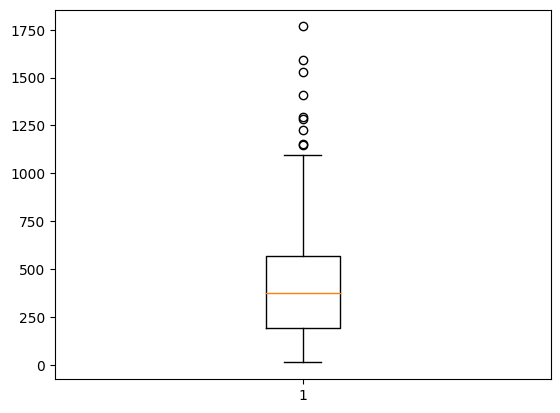

<Figure size 1000x700 with 0 Axes>

In [13]:
plt.boxplot(survival_df['Survival_days'])
fig = plt.figure(figsize =(10, 7))
plt.show()

In [14]:
X = survival_df.iloc[:, [0,2,3,4,5]]
X

,Age,NOT TUMOR,NECROTIC AND NON-ENHANCING TUMOR CORE,PERITUMORAL EDEMA,GD ENHANCING TUMOR
0,60.463,0.842147,0.011500,0.125695,0.020659
1,52.263,0.956466,0.005951,0.033328,0.004255
2,54.301,0.976365,0.000581,0.020677,0.002377
3,39.068,0.932050,0.007158,0.050617,0.010175
4,68.493,0.984766,0.002514,0.005239,0.007482
...,...,...,...,...,...
113,50.000,0.898559,0.013138,0.043237,0.045065
114,57.000,0.910677,0.017722,0.037071,0.034530
115,72.000,0.956170,0.003713,0.021395,0.018722
116,49.000,0.938822,0.000976,0.047992,0.012210


In [15]:
Y = survival_df.iloc[:, 1]
Y

0      289.0
1      616.0
2      464.0
3      788.0
4      465.0
       ...  
113    540.0
114     62.0
115    633.0
116    442.0
117    145.0
Name: Survival_days, Length: 118, dtype: float64

In [17]:
import seaborn as sns

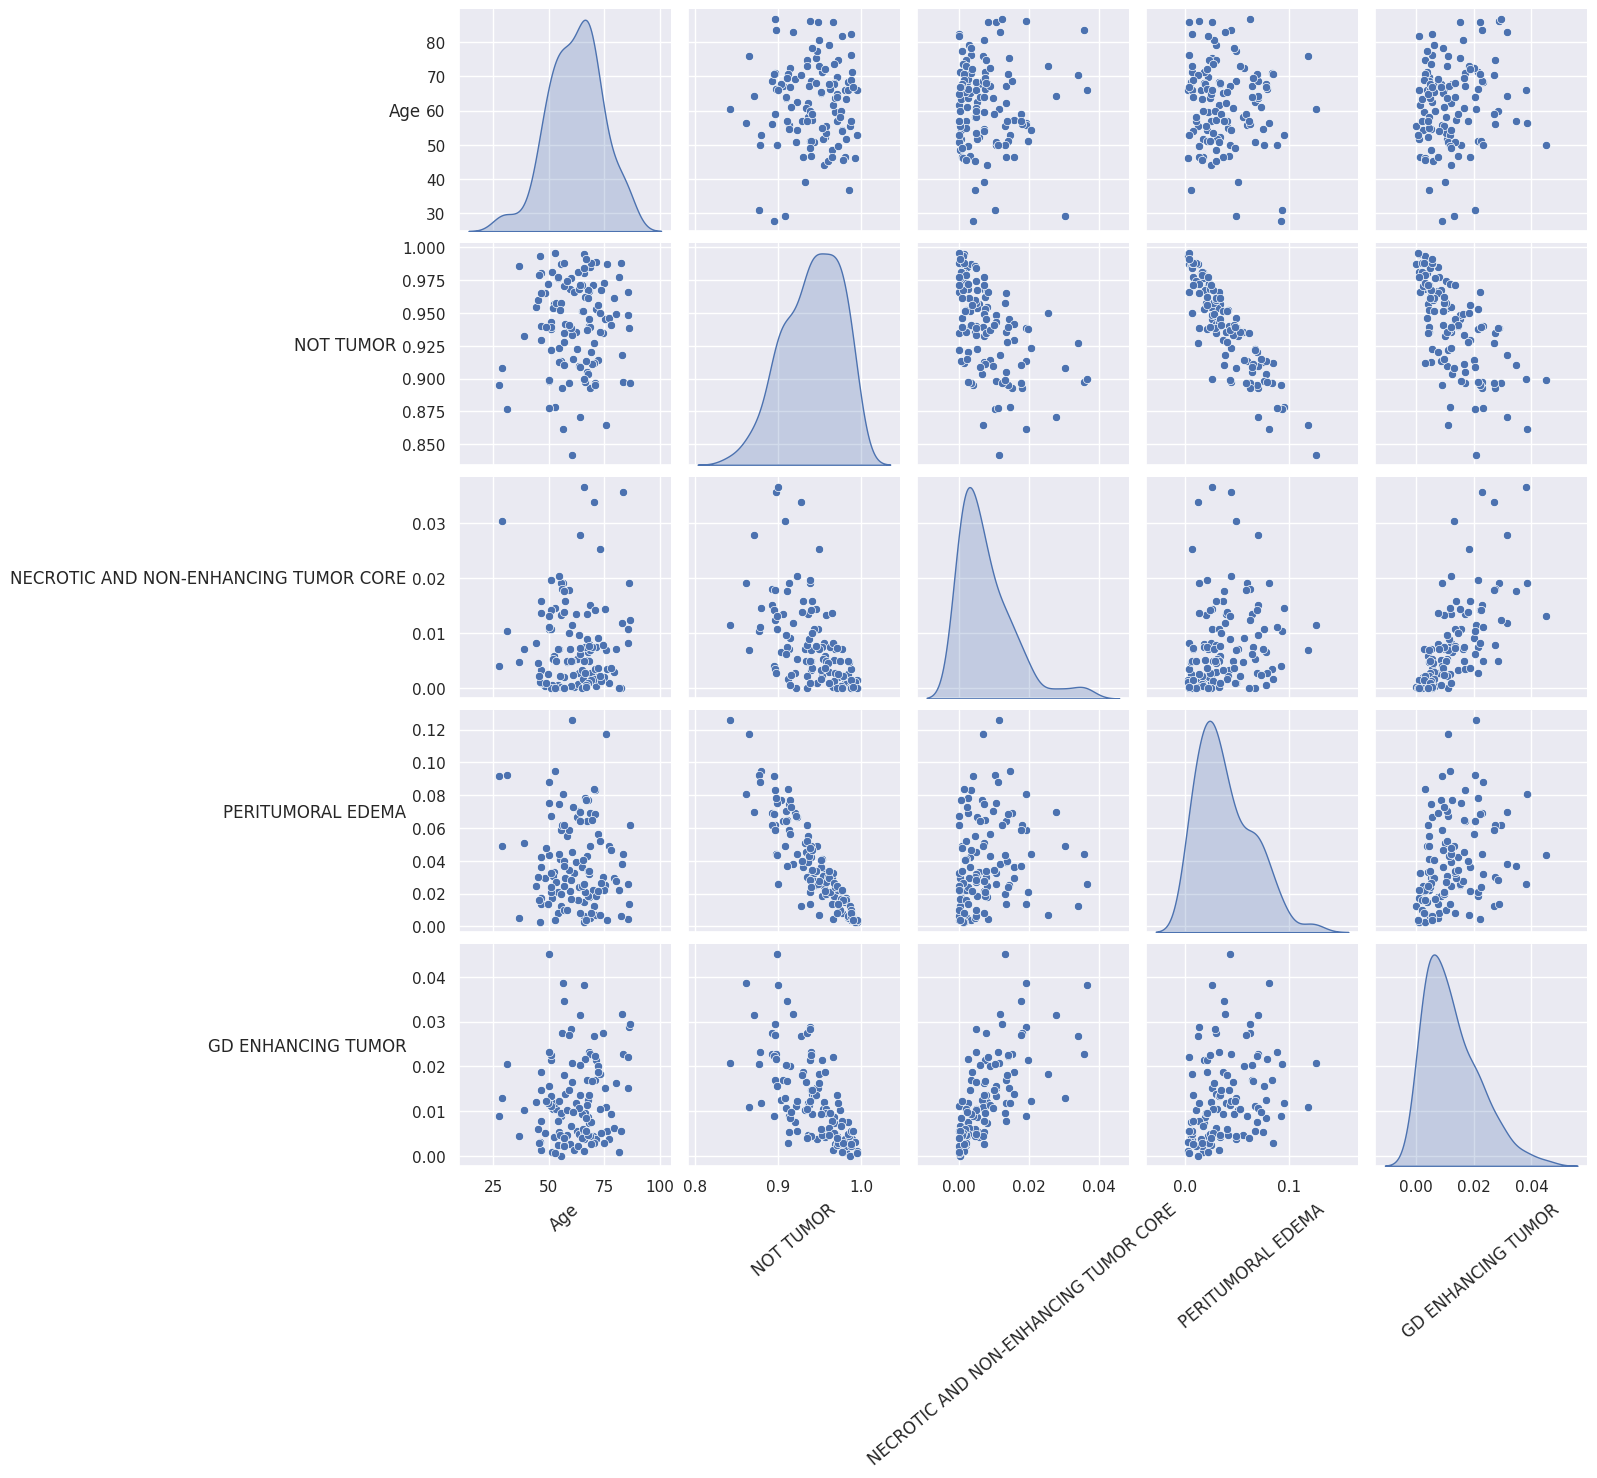

In [23]:
sns.set()

df = pd.DataFrame(X, columns = ["Age", "NOT TUMOR",	"NECROTIC AND NON-ENHANCING TUMOR CORE",	"PERITUMORAL EDEMA",	"GD ENHANCING TUMOR"])

g = sns.pairplot(df, diag_kind='kde')

for ax in g.axes.flatten():
    if ax:
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation = 40)
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation = 0)
        # set y labels alignment
        ax.yaxis.get_label().set_horizontalalignment('right')

plt.show()

In [107]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [108]:
X_normalized

,Age,NOT TUMOR,NECROTIC AND NON-ENHANCING TUMOR CORE,PERITUMORAL EDEMA,GD ENHANCING TUMOR
0,0.554919,0.000000,0.313369,1.000000,0.457617
1,0.415561,0.745381,0.162168,0.249520,0.093082
2,0.450196,0.875127,0.015838,0.146726,0.051357
3,0.191312,0.586187,0.195045,0.389992,0.224649
4,0.691389,0.929902,0.068499,0.021294,0.164790
...,...,...,...,...,...
113,0.377101,0.367819,0.358017,0.330031,1.000000
114,0.496066,0.446832,0.482927,0.279927,0.765873
115,0.750990,0.743455,0.101170,0.152564,0.414577
116,0.360106,0.630342,0.026585,0.368663,0.269873


In [109]:
X_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 5 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Age                                    118 non-null    float64
 1   NOT TUMOR                              118 non-null    float64
 2   NECROTIC AND NON-ENHANCING TUMOR CORE  118 non-null    float64
 3   PERITUMORAL EDEMA                      118 non-null    float64
 4   GD ENHANCING TUMOR                     118 non-null    float64
dtypes: float64(5)
memory usage: 4.7 KB


In [110]:
X_normalized.isnull().sum()

Age                                      0
NOT TUMOR                                0
NECROTIC AND NON-ENHANCING TUMOR CORE    0
PERITUMORAL EDEMA                        0
GD ENHANCING TUMOR                       0
dtype: int64

In [111]:
correlation = df.corr()

<Axes: >

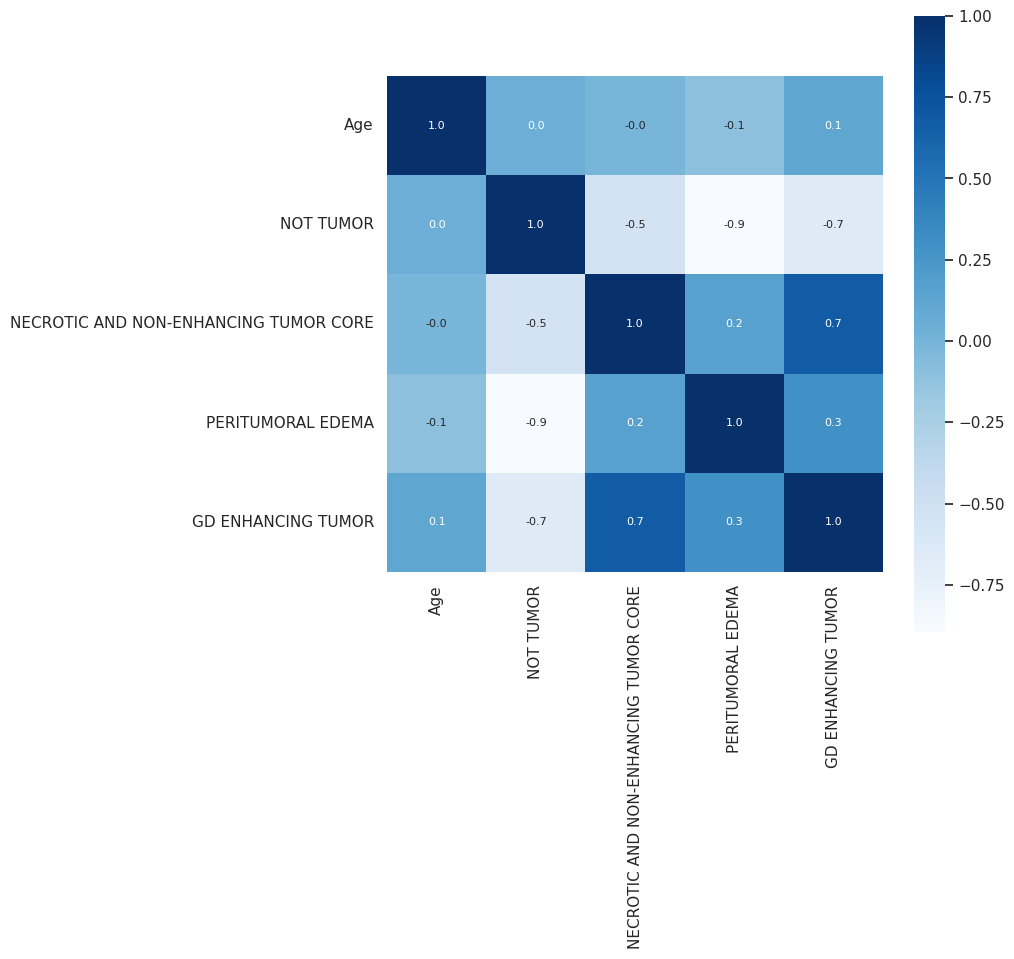

In [112]:
plt.figure(figsize = (8,8))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f',annot=True, annot_kws={'size':8}, cmap='Blues')

In [113]:
correlation1 = X_normalized.corr()

<Axes: >

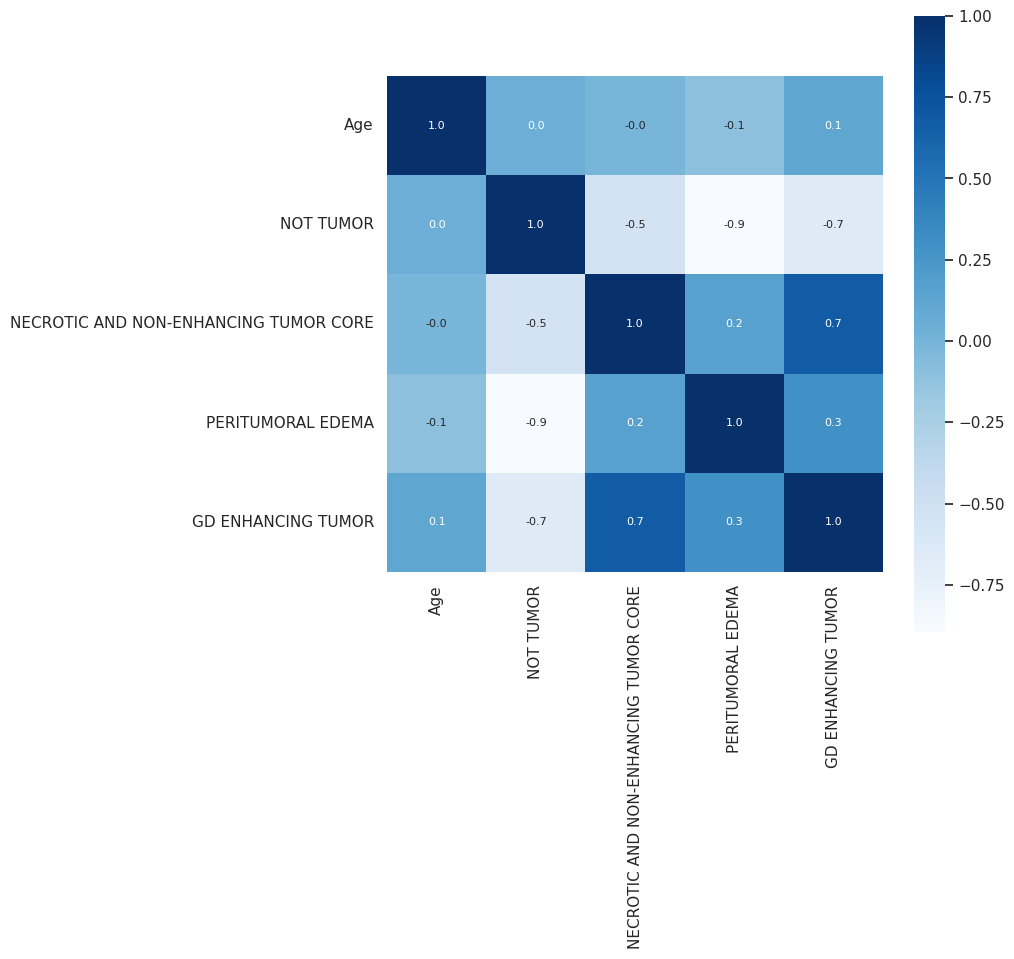

In [114]:
plt.figure(figsize = (8,8))
sns.heatmap(correlation1, cbar=True, square=True, fmt='.1f',annot=True, annot_kws={'size':8}, cmap='Blues')

In [115]:
X_normalized = X_normalized.apply(pd.to_numeric, errors='coerce')
Y = Y.apply(pd.to_numeric, errors='coerce')

In [116]:
X_normalized.fillna(0, inplace=True)
Y.fillna(0, inplace=True)

In [24]:
from sklearn.model_selection import train_test_split

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized,Y,test_size = 0.2, random_state = 44, shuffle = True)

print("x_train shape:",X_train.shape)
print("x_test shape:", X_train.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (94, 5)
x_test shape: (94, 5)
y_train shape: (94,)
y_test shape: (24,)


Linear Regression

In [118]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.2847870743205514

In [119]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, Y, cv=cv)

array([ 0.03436432,  0.38567243,  0.17347181,  0.02046176, -1.19271044])

In [120]:
lin_x = model.predict(X_test)
lin_y = list(y_test)

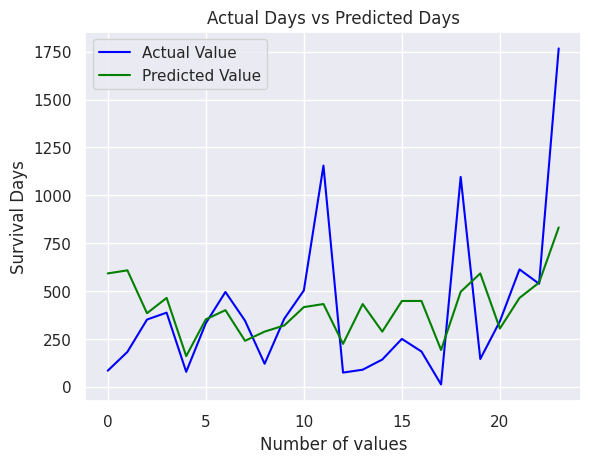

In [121]:
plt.plot(lin_y, color='blue', label = 'Actual Value')
plt.plot(lin_x, color='green', label='Predicted Value')
plt.title('Actual Days vs Predicted Days')
plt.xlabel('Number of values')
plt.ylabel('Survival Days')
plt.legend()
plt.show()

In [122]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
               
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,Y)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_para

,model,best_score,best_params
0,linear_regression,-0.115748,{}
1,lasso,-0.054526,{}
2,decision_tree,-2.367243,{'criterion': 'friedman_mse'}


Random Forest Regression

In [123]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [30]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [124]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [128]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [41]:
rf1 = RandomForestRegressor(n_estimators = 400, min_samples_split=10, min_samples_leaf=4, max_features = 'auto', max_depth = 20, bootstrap=True, random_state = 0).fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [132]:
rf = RandomForestRegressor(n_estimators = 1400, min_samples_split=5, min_samples_leaf=4, max_features = 'auto', max_depth = 20, bootstrap=True, random_state = 0).fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [135]:
rf.score(X_test,y_test)

0.1456935446652171

In [136]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_accuracy = evaluate(rf, X_test, y_test)

Model Performance
Average Error: 266.1023 degrees.
Accuracy = -121.20%.


In [137]:
test_data_prediction = rf.predict(X_test)
Y_test = list(y_test)

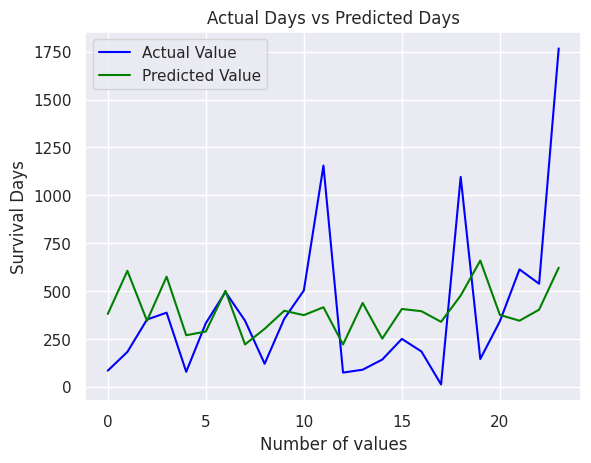

In [138]:
plt.plot(Y_test, color='blue', label = 'Actual Value')
plt.plot(test_data_prediction, color='green', label='Predicted Value')
plt.title('Actual Days vs Predicted Days')
plt.xlabel('Number of values')
plt.ylabel('Survival Days')
plt.legend()
plt.show()

KNN

In [139]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [140]:
from sklearn import metrics
import numpy as np
mean_acc = np.zeros(20)
for i in range(1,21):
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat= knn.predict(X_test)
    mean_acc[i-1] = metrics.accuracy_score(y_test, yhat)

In [141]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, cohen_kappa_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import numpy as np

In [142]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("Accuracy on training set: {:.5f}".format(knn.score(X_train, y_train)))
print("Accuracy on test set: {:.5f}".format(knn.score(X_test, y_test)))
predications = knn.predict(X_test)
print("Out of total 634 samples "+str(metrics.accuracy_score(y_test, predications,normalize = False))+" samples were predicted correctly")

Accuracy on training set: 0.31915
Accuracy on test set: 0.00000
Out of total 634 samples 0 samples were predicted correctly


In [152]:
from math import sqrt
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    knn.fit(X_train, y_train)
    pred=knn.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 450.3916351354674
RMSE value for k=  2 is: 450.3916351354674
RMSE value for k=  3 is: 450.3916351354674
RMSE value for k=  4 is: 450.3916351354674
RMSE value for k=  5 is: 450.3916351354674
RMSE value for k=  6 is: 450.3916351354674
RMSE value for k=  7 is: 450.3916351354674
RMSE value for k=  8 is: 450.3916351354674
RMSE value for k=  9 is: 450.3916351354674
RMSE value for k=  10 is: 450.3916351354674
RMSE value for k=  11 is: 450.3916351354674
RMSE value for k=  12 is: 450.3916351354674
RMSE value for k=  13 is: 450.3916351354674
RMSE value for k=  14 is: 450.3916351354674
RMSE value for k=  15 is: 450.3916351354674
RMSE value for k=  16 is: 450.3916351354674
RMSE value for k=  17 is: 450.3916351354674
RMSE value for k=  18 is: 450.3916351354674
RMSE value for k=  19 is: 450.3916351354674
RMSE value for k=  20 is: 450.3916351354674


In [167]:
grid_params = { 'n_neighbors' : [1,2,3,4,5,6,7,8,9,10],
               'weights' : ['uniform','distance'],
               'algorithm' :['auto', 'ball_tree', 'kd_tree', 'brute'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [168]:
gs = GridSearchCV(KNeighborsClassifier(), grid_params,verbose = 1,  cv=2, n_jobs = -1)

In [169]:
g_res = gs.fit(X_train, y_train)

Fitting 2 folds for each of 240 candidates, totalling 480 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


In [170]:
g_res.best_params_

{'algorithm': 'auto',
 'metric': 'minkowski',
 'n_neighbors': 1,
 'weights': 'uniform'}

In [162]:
# use the best hyperparameters
knn = KNeighborsClassifier(n_neighbors = 1, weights = 'uniform',algorithm = 'auto',metric = 'minkowski',p=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1, p=1)

In [163]:
# get a prediction
y_hat = knn.predict(X_train)
y_knn = knn.predict(X_test)

In [164]:
print('Training set accuracy: ', metrics.accuracy_score(y_train, y_hat))
print('Test set accuracy: ',metrics.accuracy_score(y_test, y_knn))

Training set accuracy:  1.0
Test set accuracy:  0.0


In [171]:
knn_x = knn.predict(X_test)
knn_y = list(y_test)

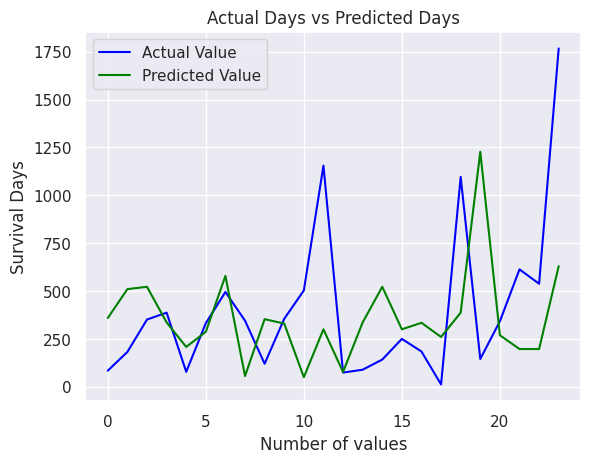

In [172]:
plt.plot(knn_y, color='blue', label = 'Actual Value')
plt.plot(knn_x, color='green', label='Predicted Value')
plt.title('Actual Days vs Predicted Days')
plt.xlabel('Number of values')
plt.ylabel('Survival Days')
plt.legend()
plt.show()

Ridge Regression

In [51]:
from sklearn.linear_model import Ridge

In [52]:
rid = Ridge(alpha = 0.5, tol = 0.001, \
              solver ='auto', random_state = 42)
rid.fit(X_train, y_train)

Ridge(alpha=0.5, random_state=42, tol=0.001)

In [53]:
y_pred = rid.predict(X_test) 

In [54]:
score = rid.score(X_test, y_test)
print("Model score : ", score)

Model score :  0.2755153133631302


In [55]:
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

In [56]:
rid = Ridge()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(rid, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -225.188
Config: {'alpha': 0.99}


In [59]:
rid = Ridge(alpha = 0.99, tol = 0.001, \
              solver ='auto', random_state = 42)
rid.fit(X_train, y_train)

Ridge(alpha=0.99, random_state=42, tol=0.001)

In [60]:
score = rid.score(X_test, y_test)
print("Model score : ", score)

Model score :  0.27965470754072685


In [61]:
from sklearn.linear_model import RidgeCV

In [62]:
rid1 = RidgeCV(alphas=arange(0.001, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')
# fit model
rid1.fit(X_train, y_train)

RidgeCV(alphas=array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171,
       0.181, 0.191, 0.201, 0.211, 0.221, 0.231, 0.241, 0.251, 0.261,
       0.271, 0.281, 0.291, 0.301, 0.311, 0.321, 0.331, 0.341, 0.351,
       0.361, 0.371, 0.381, 0.391, 0.401, 0.411, 0.421, 0.431, 0.441,
       0.451, 0.461, 0.471, 0.481, 0.491, 0.501, 0.511, 0.521, 0.531,
       0.54....571, 0.581, 0.591, 0.601, 0.611, 0.621,
       0.631, 0.641, 0.651, 0.661, 0.671, 0.681, 0.691, 0.701, 0.711,
       0.721, 0.731, 0.741, 0.751, 0.761, 0.771, 0.781, 0.791, 0.801,
       0.811, 0.821, 0.831, 0.841, 0.851, 0.861, 0.871, 0.881, 0.891,
       0.901, 0.911, 0.921, 0.931, 0.941, 0.951, 0.961, 0.971, 0.981,
       0.991]),
        cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
        scoring='neg_mean_absolute_error')

In [63]:
score = rid1.score(X_test, y_test)
print("Model score : ", score)

Model score :  0.2796595712534258


In [91]:
rid_pred = rid1.predict(X_test)

In [94]:
from sklearn.metrics import mean_squared_error
mean = mean_squared_error(y_test, rid_pred) 
rid_rmse = np.sqrt(mean_squared_error(y_test,rid_pred))

In [95]:
print("RMSE : ", rid_rmse)

RMSE :  342.41723119358994


In [81]:
rid_x = model.predict(X_test)
rid_y = list(y_test)

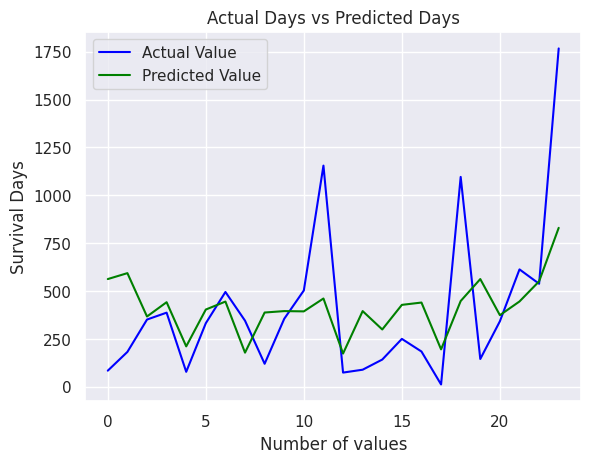

In [83]:
plt.plot(rid_y, color='blue', label = 'Actual Value')
plt.plot(rid_x, color='green', label='Predicted Value')
plt.title('Actual Days vs Predicted Days')
plt.xlabel('Number of values')
plt.ylabel('Survival Days')
plt.legend()
plt.show()

Lasso

In [69]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
LassoRegression = Lasso()
hyperParameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
LassoRegressor = GridSearchCV(LassoRegression, hyperParameters, scoring='neg_mean_squared_error', cv=5)
LassoRegressor.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.283e+06, tolerance: 6.017e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.062e+06, tolerance: 7.246e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.540e+06, tolerance: 8.468e+02

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             scoring='neg_mean_squared_error')

In [70]:
print("Best value for lambda : ",LassoRegressor.best_params_)
print("Best score for cost function: ", LassoRegressor.best_score_)

Best value for lambda :  {'alpha': 5}
Best score for cost function:  -98626.24077398323


Lasso and Ridge

In [71]:
from sklearn import metrics
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split

In [72]:
def test(models, X, Y, iterations = 100):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                Y, 
                                                                test_size= 0.2)
            r2_test.append(metrics.r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(metrics.r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)

In [73]:
models = {'OLS': linear_model.LinearRegression(),
         'Lasso': linear_model.Lasso(),
         'Ridge': linear_model.Ridge(),}

In [74]:
test(models, X, Y)

,OLS,Lasso,Ridge
0,0.221683,0.197747,0.196805
1,0.027558,-0.002981,0.025603


In [75]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

models2 = {'OLS': linear_model.LinearRegression(),
           'Lasso': GridSearchCV(linear_model.Lasso(), 
                               param_grid=lasso_params).fit(X,Y).best_estimator_,
           'Ridge': GridSearchCV(linear_model.Ridge(), 
                               param_grid=ridge_params).fit(X,Y).best_estimator_,}

In [78]:
test(models, X, Y)

,OLS,Lasso,Ridge
0,0.230363,0.199115,0.199716
1,0.060455,0.035839,0.035631


In [79]:
lasso_params = {'fit__alpha':[0.005, 0.02, 0.03, 0.05, 0.06]}
ridge_params = {'fit__alpha':[550, 580, 600, 620, 650]}

pipe1 = Pipeline([('poly', PolynomialFeatures()),
                 ('fit', linear_model.LinearRegression())])
pipe2 = Pipeline([('poly', PolynomialFeatures()),
                 ('fit', linear_model.Lasso())])
pipe3 = Pipeline([('poly', PolynomialFeatures()),
                 ('fit', linear_model.Ridge())])

models3 = {'OLS': pipe1,
           'Lasso': GridSearchCV(pipe2, 
                                 param_grid=lasso_params).fit(X,Y).best_estimator_ ,
           'Ridge': GridSearchCV(pipe3, 
                                 param_grid=ridge_params).fit(X,Y).best_estimator_,}

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.348e+06, tolerance: 1.217e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.953e+06, tolerance: 9.716e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.661e+06, tolerance: 1.018e+03

In [80]:
test(models, X, Y)

,OLS,Lasso,Ridge
0,0.225199,0.195611,0.197248
1,0.068115,0.077960,0.067584


**Neural Network**

In [173]:
TargetVariable=['Survival_days']
Predictors=['Age', 'NOT TUMOR', 'NECROTIC AND NON-ENHANCING TUMOR CORE', 'PERITUMORAL EDEMA', 'GD ENHANCING TUMOR']
 
X=survival_df[Predictors].values
y=survival_df[TargetVariable].values
 
### Sandardization of data ###
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)
 
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)
 
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(82, 5)
(82, 1)
(36, 5)
(36, 1)


In [174]:
from tensorflow import keras
from tensorflow.keras import layers

In [183]:
from keras.models import Sequential
from keras.layers import Dense
 
# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=5, input_dim=5, kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))

model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))

model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))
  
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))
 
opt = keras.optimizers.Adam(learning_rate=0.01)
# Compiling the model
model.compile(loss='mean_squared_error', optimizer=opt)
 
# Fitting the ANN to the Training set
dl = model.fit(X_train, y_train ,batch_size = 4, epochs = 100, verbose=1)

Epoch 1/100
21/21 [==============================] - 2s 2ms/step - loss: 1.1226
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 1.1064
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 1.1088
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 1.1097
Epoch 5/100
21/21 [==============================] - 0s 2ms/step - loss: 1.1076
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 1.1087
Epoch 7/100
21/21 [==============================] - 0s 2ms/step - loss: 1.1074
Epoch 8/100
21/21 [==============================] - 0s 2ms/step - loss: 1.1078
Epoch 9/100
21/21 [==============================] - 0s 2ms/step - loss: 1.1072
Epoch 10/100
21/21 [==============================] - 0s 3ms/step - loss: 1.1079
Epoch 11/100
21/21 [==============================] - 0s 2ms/step - loss: 1.1067
Epoch 12/100
21/21 [==============================] - 0s 2ms/step - loss: 1.1095
Epoch 13/100
21/21 [=================

In [176]:
model.save_weights('my_model_weights.h5')

In [177]:
def percentage_difference(y_true, y_pred):
    return (abs(y_pred/y_true - 1) * 100)

In [178]:
# create ANN model
model1 = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model1.add(Dense(units=5, input_dim=5, kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model1.add(Dense(units=5, kernel_initializer='normal', activation='selu'))

model1.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))

model1.add(Dense(units=5, kernel_initializer='normal', activation='selu'))

# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model1.add(Dense(1, kernel_initializer='normal'))
 
opt1 = keras.optimizers.Adam(learning_rate=0.0099)
# Compiling the model
model1.compile(loss='mean_squared_error', optimizer=opt1, metrics=['accuracy',percentage_difference])
 
# Fitting the ANN to the Training set
dl1 = model1.fit(X_train, y_train ,batch_size = 4, epochs = 100, verbose=1)

Epoch 1/100
21/21 [==============================] - 1s 2ms/step - loss: 1.1131 - accuracy: 0.0000e+00 - percentage_difference: 104.7979
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 1.1076 - accuracy: 0.0000e+00 - percentage_difference: 101.0218
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 1.1128 - accuracy: 0.0000e+00 - percentage_difference: 100.6078
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 1.0670 - accuracy: 0.0000e+00 - percentage_difference: 99.7162
Epoch 5/100
21/21 [==============================] - 0s 2ms/step - loss: 0.9606 - accuracy: 0.0000e+00 - percentage_difference: 403.3725
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 0.9197 - accuracy: 0.0000e+00 - percentage_difference: 153.1134
Epoch 7/100
21/21 [==============================] - 0s 2ms/step - loss: 0.8494 - accuracy: 0.0000e+00 - percentage_difference: 294.3495
Epoch 8/100
21/21 [=======================

In [179]:
model1.save_weights('my_model_weights_ann.h5')

In [180]:
MAPE = np.mean(100 * (np.abs(y_test-model1.predict(X_test))/y_test))

2/2 [==============================] - 0s 11ms/step


In [181]:
print("MAPE : ", MAPE)

MAPE :  -72.10367068700859


In [184]:
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses
from sklearn.utils import shuffle

In [195]:
def create_model(init_mode='uniform'):
    # define model
    # model = Sequential()
    # model.add(Dense(5, kernel_initializer=init_mode, activation=tf.nn.relu, input_dim=5)) 
    # model.add(Dropout(0.1))
    # model.add(Dense(5, kernel_initializer=init_mode, activation=tf.nn.relu))
    # model.add(Dense(5, kernel_initializer=init_mode, activation=tf.nn.softmax))

    # Defining the Input layer and FIRST hidden layer, both are same!
    model.add(Dense(units=5, input_dim=5, kernel_initializer='normal', activation=tf.nn.relu))
    model.add(Dropout(0.1))
    
    # Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically

    model.add(Dense(units=5, kernel_initializer=init_mode, activation=tf.nn.relu))

    model.add(Dense(units=5, kernel_initializer=init_mode, activation=tf.nn.softmax))
      
    # The output neuron is a single fully connected node 
    # Since we will be predicting a single number
    model.add(Dense(1, kernel_initializer=init_mode))


    # compile model
    model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
    return model

In [196]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [197]:
%%time
seed = 7
numpy.random.seed(seed)
batch_size = 5
epochs = 100

model_CV = KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=1)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 
             'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

<timed exec>:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/100


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
  File "<ipytho

17/17 [==============================] - 1s 2ms/step - loss: 4.7960e-06 - accuracy: 0.0122 
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 4.7960e-06 - accuracy: 0.0122
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 4.7960e-06 - accuracy: 0.0122
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 4.7960e-06 - accuracy: 0.0122
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 4.7960e-06 - accuracy: 0.0122
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: 4.7960e-06 - accuracy: 0.0122
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 4.7960e-06 - accuracy: 0.0122
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: 4.7960e-06 - accuracy: 0.0122
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - loss: 4.7960e-06 - accuracy: 0.0122
Epoch 10/100
17/17 [==============================] - 0s 3ms/step - loss: 4.7960e-06

In [198]:
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.011904762436946234 using {'init_mode': 'uniform'}
 mean=0.0119, std=0.01684 using {'init_mode': 'uniform'}
 mean=0.0119, std=0.01684 using {'init_mode': 'lecun_uniform'}
 mean=nan, std=nan using {'init_mode': 'normal'}
 mean=nan, std=nan using {'init_mode': 'zero'}
 mean=nan, std=nan using {'init_mode': 'glorot_normal'}
 mean=nan, std=nan using {'init_mode': 'glorot_uniform'}
 mean=0.0119, std=0.01684 using {'init_mode': 'he_normal'}
 mean=0.0119, std=0.01684 using {'init_mode': 'he_uniform'}
